In [2]:
## Required Libraries and Methods

import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, validation_curve

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 150)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from pandas.core.common import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
## Exploratory Data Analysis

# Get the Data

df = pd.read_csv('hitters.csv')

df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500,N


In [4]:
df.shape

(322, 20)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AtBat,322.000,380.929,153.405,16.000,255.250,379.500,512.000,687.000
Hits,322.000,101.025,46.455,1.000,64.000,96.000,137.000,238.000
HmRun,322.000,10.770,8.709,0.000,4.000,8.000,16.000,40.000
Runs,322.000,50.910,26.024,0.000,30.250,48.000,69.000,130.000
RBI,322.000,48.028,26.167,0.000,28.000,44.000,64.750,121.000
Walks,322.000,38.742,21.639,0.000,22.000,35.000,53.000,105.000
Years,322.000,7.444,4.926,1.000,4.000,6.000,11.000,24.000
CAtBat,322.000,2648.683,2324.206,19.000,816.750,1928.000,3924.250,14053.000
CHits,322.000,717.571,654.473,4.000,209.000,508.000,1059.250,4256.000
CHmRun,322.000,69.491,86.266,0.000,14.000,37.500,90.000,548.000


In [10]:
# Grabbing Numerical and Categorical Variables with Function

def grab_col_names(dataframe, cat_th=8, car_th=20):
 
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols, cat_but_car

In [11]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


In [12]:
# Categorical Variables Analysis with Function

def cat_summary(dataframe, col_name, plot=False):

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##################")

In [13]:
for col in cat_cols:
    cat_summary(df, col)

   League  Ratio
A     175 54.348
N     147 45.652
##################
   Division  Ratio
W       165 51.242
E       157 48.758
##################
   NewLeague  Ratio
A        176 54.658
N        146 45.342
##################


In [14]:
# Numerical Variables Analysis with Function

def num_summary(dataframe, numerical_col, plot=False):

    quantiles = [0.05, 0.10, 0.50, 0.90, 0.95, 0.99]

    print(dataframe[numerical_col].describe(quantiles).T)

In [15]:
for col in num_cols:
    num_summary(df, col)

count   322.000
mean    380.929
std     153.405
min      16.000
5%      161.000
10%     194.100
50%     379.500
90%     584.900
95%     609.900
99%     658.590
max     687.000
Name: AtBat, dtype: float64
count   322.000
mean    101.025
std      46.455
min       1.000
5%       39.000
10%      45.100
50%      96.000
90%     163.000
95%     174.000
99%     210.790
max     238.000
Name: Hits, dtype: float64
count   322.000
mean     10.770
std       8.709
min       0.000
5%        0.000
10%       1.000
50%       8.000
90%      24.000
95%      28.950
99%      33.000
max      40.000
Name: HmRun, dtype: float64
count   322.000
mean     50.910
std      26.024
min       0.000
5%       17.000
10%      20.100
50%      48.000
90%      89.000
95%      94.000
99%     107.790
max     130.000
Name: Runs, dtype: float64
count   322.000
mean     48.028
std      26.167
min       0.000
5%       14.000
10%      19.000
50%      44.000
90%      86.000
95%      96.000
99%     112.370
max     121.000
Name: RBI,

In [16]:
# Target Variable Analysis with Function

def target_summary_with_cat(dataframe, target, categorical_col):

    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [17]:
for col in cat_cols:
    target_summary_with_cat(df, "Salary", col)

        TARGET_MEAN
League             
A           542.000
N           529.118


          TARGET_MEAN
Division             
E             624.271
W             450.877


           TARGET_MEAN
NewLeague             
A              537.113
N              534.554




In [18]:
# Correlation Analysis

def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show(block=True)
    return drop_list


C:\Users\Sinan Duman\AppData\Local\Temp\ipykernel_23776\2177056226.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))


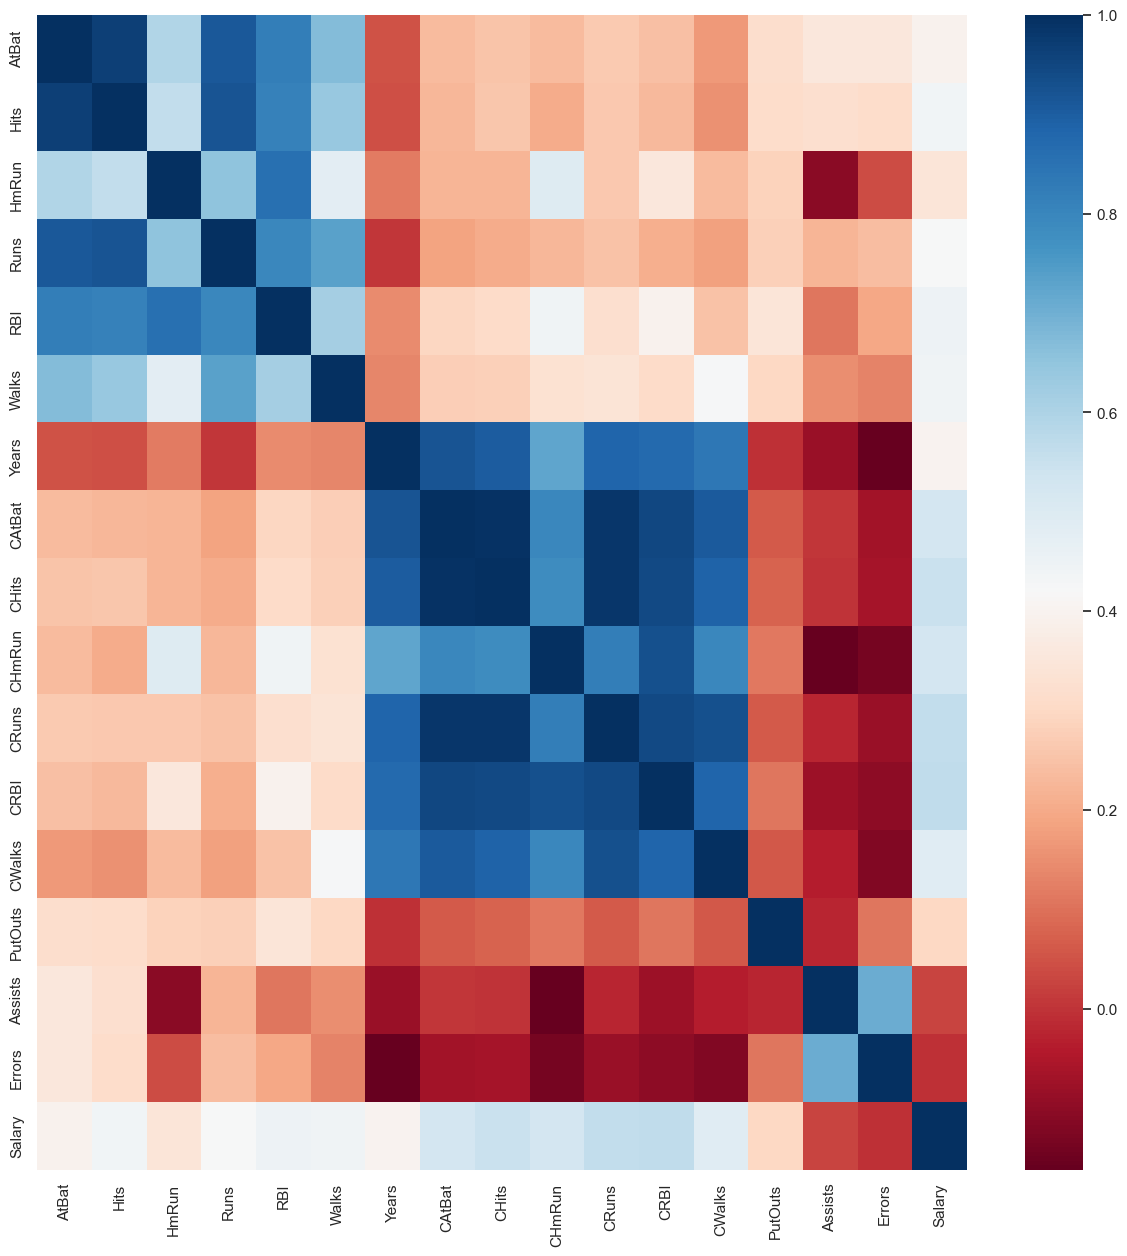

['Hits', 'Runs', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks']

In [19]:
high_correlated_cols(df, plot=True)

In [20]:
## Advanced Functional Exploratory Data Analysis

# Outlier Analysis

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [21]:
for col in num_cols:
    print(col, check_outlier(df, col))

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits False
CHmRun False
CRuns False
CRBI False
CWalks False
PutOuts False
Assists False
Errors False
Salary False


In [22]:
for col in num_cols:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

In [23]:
# Missing Values Analysis

df.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [24]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [25]:
missing_values_table(df)


        n_miss  ratio
Salary      59 18.320


In [26]:
df.dropna(inplace=True)

In [27]:
# Feature Extraction

df['NEW_RBI'] = df['RBI'] / df['CRBI']
df["NEW_CRBI*CATBAT"] = df['CRBI'] * df['CAtBat']
df["NEW_RBI"] = df["RBI"] / df["CRBI"]
df["NEW_CHmRun"] = df["CHmRun"] * df["Years"]
df["NEW_CRuns"] = df["CRuns"] / df["Years"]
df["NEW_Chits"] = df["CHits"] * df["Years"]
df["NEW_CHm_CAT"] = df["CHmRun"] / df["CAtBat"]
df['NEW_Diff_Atbat'] = df['AtBat'] - (df['CAtBat'] / df['Years'])
df['NEW_Diff_Hits'] = df['Hits'] - (df['CHits'] / df['Years'])
df['NEW_Diff_HmRun'] = df['HmRun'] - (df['CHmRun'] / df['Years'])
df['NEW_Diff_Walks'] = df['Walks'] - (df['CWalks'] / df['Years'])
df['NEW_Hits'] = df['Hits'] / df['CHits'] + df['Hits']

In [28]:
df.shape

(263, 31)

In [29]:
# One-Hot Encoding

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [30]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [31]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_RBI,NEW_CRBI*CATBAT,NEW_CHmRun,NEW_CRuns,NEW_Chits,NEW_CHm_CAT,NEW_Diff_Atbat,NEW_Diff_Hits,NEW_Diff_HmRun,NEW_Diff_Walks,NEW_Hits,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.000,0.092,1427886,966,22.929,11690,0.020,68.643,21.357,2.071,12.214,81.097,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.000,0.271,431984,189,74.667,1371,0.039,-62.333,-22.333,-3.000,-11.667,130.284,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.000,0.093,4716264,2475,75.273,17325,0.040,-15.636,-2.182,-0.455,4.818,141.090,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.500,0.913,18216,24,24.000,202,0.030,123.000,36.500,4.000,13.500,87.861,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.000,0.152,1481088,209,45.545,12463,0.004,193.273,66.000,2.273,17.364,169.149,0,1,0


In [32]:
# Feature Scaling

cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if col not in ["Salary"]]

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

Observations: 263
Variables: 31
cat_cols: 3
num_cols: 28
cat_but_car: 0
num_but_cat: 3


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_RBI,NEW_CRBI*CATBAT,NEW_CHmRun,NEW_CRuns,NEW_Chits,NEW_CHm_CAT,NEW_Diff_Atbat,NEW_Diff_Hits,NEW_Diff_HmRun,NEW_Diff_Walks,NEW_Hits,League_N,Division_W,NewLeague_N
1,-0.603,-0.596,-0.529,-1.206,-0.522,-0.098,1.398,0.347,0.174,-0.003,-0.122,0.259,0.435,1.221,-0.523,0.213,475.000,-0.830,-0.056,0.128,-1.060,0.308,-0.317,0.004,0.102,-0.195,0.212,-0.601,1,1,1
2,0.513,0.492,0.730,0.442,0.794,1.609,-0.901,-0.453,-0.410,-0.076,-0.415,-0.200,0.010,2.109,-0.254,0.820,480.000,-0.226,-0.425,-0.436,1.393,-0.567,0.898,-1.120,-1.184,-1.188,-1.458,0.492,0,1,0
3,0.628,0.736,0.959,0.402,1.026,-0.190,0.771,1.302,1.318,1.899,1.412,1.573,0.356,-0.325,-0.744,-0.848,500.000,-0.825,1.163,1.222,1.422,0.785,0.975,-0.719,-0.591,-0.690,-0.305,0.732,1,0,1
4,-0.562,-0.462,-0.185,-0.618,-0.367,-0.513,-1.110,-0.991,-0.960,-0.698,-0.948,-0.881,-0.862,1.841,-0.544,-0.697,91.500,1.941,-0.578,-0.556,-1.009,-0.666,0.349,0.471,0.547,0.182,0.302,-0.451,1,0,1
5,1.295,1.358,-0.872,0.755,-0.019,-0.282,0.771,0.767,0.635,-0.612,0.423,0.017,-0.251,-0.031,2.087,2.488,750.000,-0.627,-0.036,-0.421,0.012,0.373,-1.332,1.074,1.415,-0.156,0.572,1.355,0,1,0


In [33]:
# Some Base Models

y = df["Salary"]
X = df.drop(["Salary"], axis=1)

In [34]:
models = [('LR', LinearRegression()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]

## Model Performance Evaluation

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 3)} ({name}) ")

RMSE: 299.136 (LR) 
RMSE: 271.156 (RF) 
RMSE: 273.959 (GBM) 
RMSE: 287.913 (LightGBM) 
RMSE: 273.434 (CatBoost) 


In [35]:
# Hyperparameter Optimization for Best Method is Random Forest

rf_model = RandomForestRegressor(random_state=13)

rf_params = {"max_depth": [5, 8, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15],
             "n_estimators": [200, 500]}

In [36]:
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [37]:
rf_best_grid.best_params_

{'max_depth': 8,
 'max_features': 'auto',
 'min_samples_split': 8,
 'n_estimators': 200}

In [38]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=13).fit(X, y)

In [39]:
rmse = np.mean(np.sqrt(-cross_val_score(rf_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

259.749670676115

In [40]:
# Hyperparameter Optimization for Second Method is CatBoost

catboost_model = CatBoostRegressor(random_state=13, verbose=False)

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [43]:
catboost_best_grid.best_params_

{'depth': 3, 'iterations': 200, 'learning_rate': 0.1}

In [44]:
catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)

In [45]:
rmse = np.mean(np.sqrt(-cross_val_score(catboost_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

249.59361840234106

In [46]:
# Hyperparameter Optimization for GBM Model

gbm_model = GradientBoostingRegressor(random_state=17)

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}

gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [47]:
gbm_best_grid.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.7}

In [48]:
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X, y)

In [49]:
rmse = np.mean(np.sqrt(-cross_val_score(gbm_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

251.51792238240347

In [50]:
# Feature Importance

def plot_importance(model, features, num=len(X)):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()

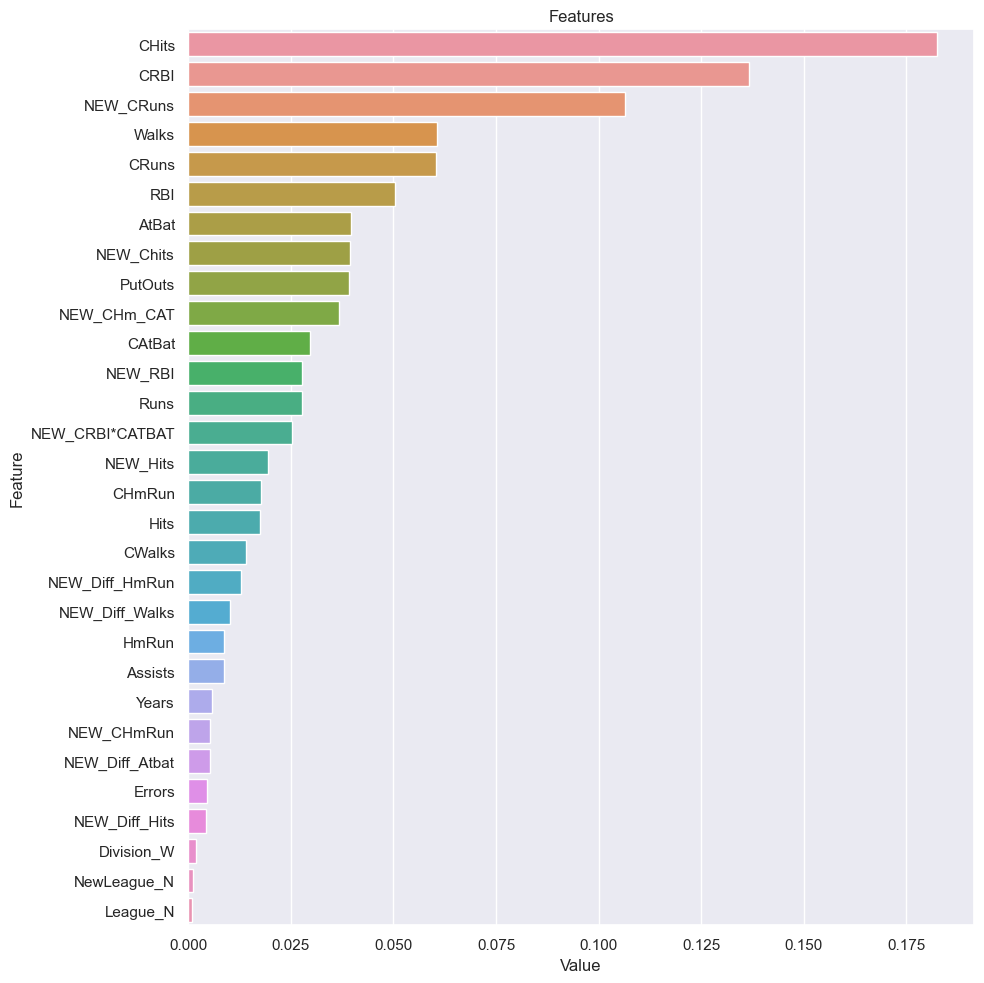

In [51]:
plot_importance(rf_final, X)

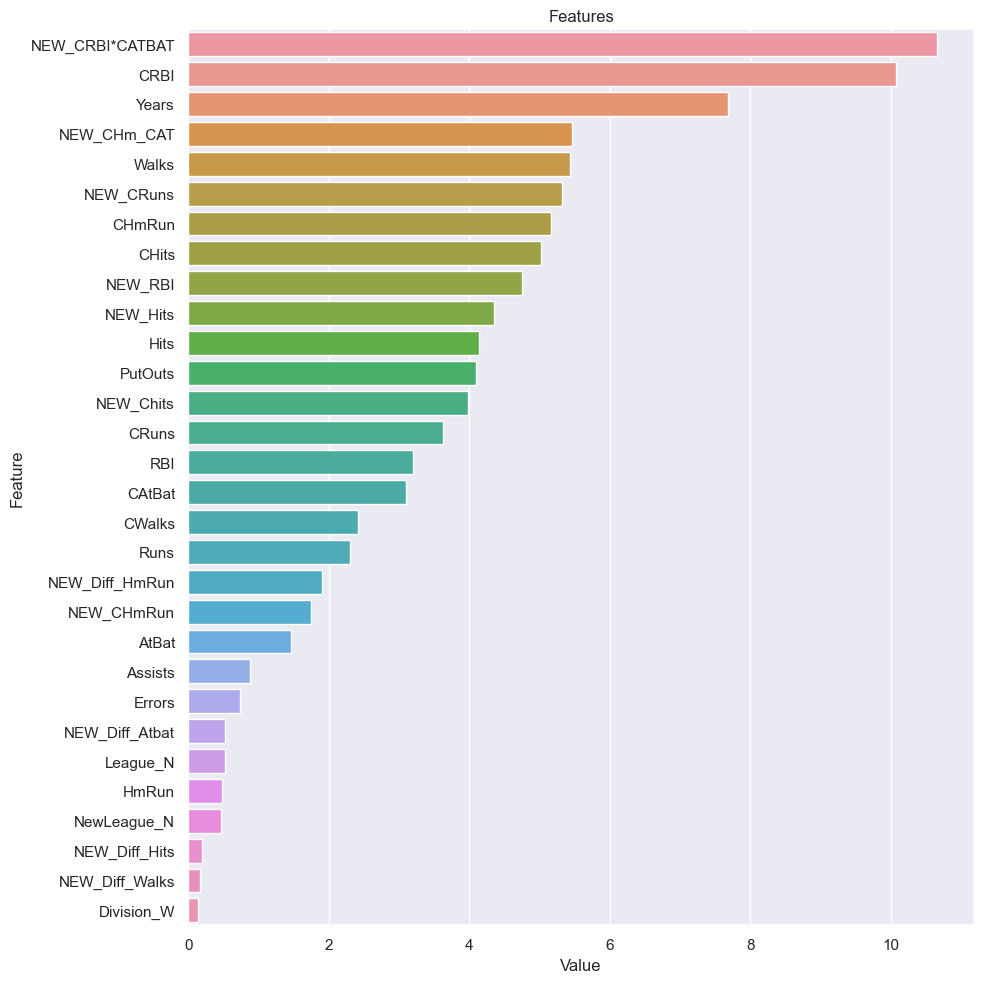

In [52]:
plot_importance(catboost_final, X)